In [16]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [17]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

In [18]:
train_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/TrainSet/'
valid_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/ValidationSet/'
test_path = 'C:/Users/Owner/Desktop/Produce Item Recognition/DataSet/TestSet/'

train_image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [19]:
import os
entries = os.listdir(train_path)
folders = glob(train_path + '/*')
train_class_dist={}
count=0
for folder in folders:
  number_of_images=glob(folder+'/*.jp*g')
  train_class_dist[entries[count]]=len(number_of_images)
  count+=1

valid_entries = os.listdir(valid_path)
valid_folders = glob(valid_path + '/*')
valid_class_dist={}
count=0
for folder in valid_folders:
  valid_number_of_images=glob(folder+'/*.jp*g')
  valid_class_dist[entries[count]]=len(valid_number_of_images)
  count+=1



In [20]:
import plotly.express as px

fig = px.bar(train_class_dist.keys(), x=list(train_class_dist.keys()), y=list(train_class_dist.values()),labels={"y":"Class Size", "x":"Fruits and Vegetables"},title="Train DataSet")
fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.show()

In [21]:

import plotly.express as px

fig = px.bar(valid_class_dist.keys(), x=list(valid_class_dist.keys()), y=list(valid_class_dist.values()),labels={"y":"Class Size", "x":"Fruits and Vegetables"},title="Validation DataSet")
fig.update_traces(texttemplate='%{y:.2s}', textposition='outside')

fig.show()

In [22]:
IMAGE_SIZE = [100, 100]
epochs = 50
train_batch_size =5
valid_batch_size=5
test_batch_size=4


In [23]:
gen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range=0,
        #zoom_range=0.4,
       

 
)
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 7680 images belonging to 24 classes.
{'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blueberry': 3, 'Brocolli': 4, 'Cabbage': 5, 'Canada Pear': 6, 'Carrot': 7, 'Garlic': 8, 'Green Peas': 9, 'Green Pepper': 10, 'Lettuce': 11, 'Mangoes': 12, 'Okra': 13, 'Orange': 14, 'Pineapple': 15, 'Red Chilli': 16, 'Red Onions': 17, 'Spinach': 18, 'Spring Onion': 19, 'Tomato': 20, 'Yellow Onion': 21, 'Yellow Potato': 22, 'bell pepper': 23}


Found 19181 images belonging to 24 classes.


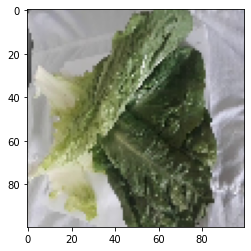

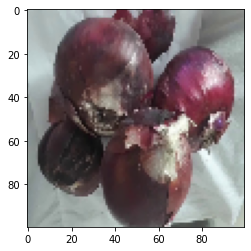

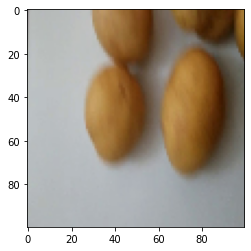

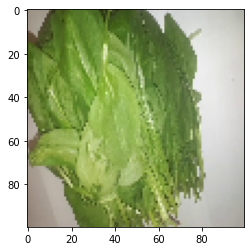

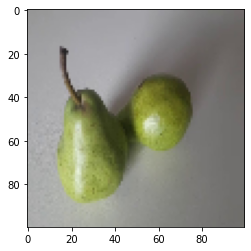

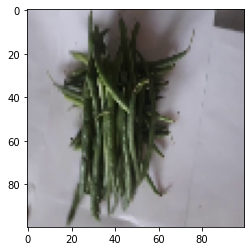

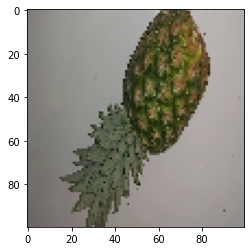

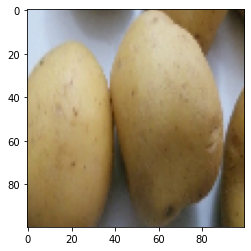

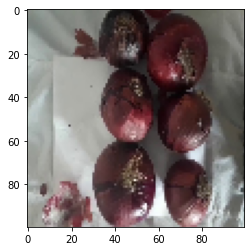

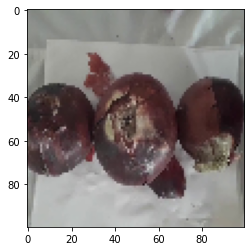

In [24]:

tgr = gen.flow_from_directory(
    train_path,
    color_mode = "rgb",
    target_size=(100,100),
    batch_size=1,
    class_mode=None)


i = 0
img_list = []
for batch in tgr:
    img_list.append(batch)
    i += 1
    if i > 9:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()

In [25]:
train_generator = gen.flow_from_directory(
  train_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=train_batch_size,
  seed=42,
    
)
valid_generator = gen.flow_from_directory(
  valid_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=valid_batch_size,
  
)
test_generator = gen.flow_from_directory(
  test_path,
  color_mode = "rgb",
  target_size=IMAGE_SIZE,
  shuffle=False,
  
)

Found 19181 images belonging to 24 classes.
Found 7680 images belonging to 24 classes.
Found 7680 images belonging to 24 classes.


In [26]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res = ResNet50(weights='imagenet',include_top=False, input_shape=(100,100,3))

# add a global spatial average pooling layer
x = res.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(24, activation='softmax')(x)
# create the full network so we can train on it
model = Model(inputs=res.input, outputs=predictions)

C:\Users\Owner\anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 989685911601419213
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416432435
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13265992860011811853
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("C:/Users/Owner/Desktop/Produce Item Recognition/res_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1, mode='auto')

r=model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  callbacks=[checkpoint,early],
  steps_per_epoch=len(train_image_files) // train_batch_size,
  validation_steps=len(valid_image_files) //valid_batch_size,
 
  
)

Epoch 1/50
3836/3836 [==============================] - 1541s 402ms/step - loss: 1.1011 - accuracy: 0.6646 - val_loss: 1.4906 - val_accuracy: 0.7229

Epoch 00001: val_accuracy improved from -inf to 0.72292, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/res_1.h5
Epoch 2/50
3836/3836 [==============================] - 1521s 396ms/step - loss: 0.2825 - accuracy: 0.9276 - val_loss: 4.0578e-04 - val_accuracy: 0.8944

Epoch 00002: val_accuracy improved from 0.72292 to 0.89440, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/res_1.h5
Epoch 3/50
3836/3836 [==============================] - 1510s 394ms/step - loss: 0.1977 - accuracy: 0.9582 - val_loss: 0.0000e+00 - val_accuracy: 0.9557

Epoch 00003: val_accuracy improved from 0.89440 to 0.95573, saving model to C:/Users/Owner/Desktop/Produce Item Recognition/res_1.h5
Epoch 4/50
3836/3836 [==============================] - 1505s 392ms/step - loss: 0.1646 - accuracy: 0.9671 - val_loss: 4.7684e-08 - val_accuracy: 

In [30]:
model.save("C:/Users/Owner/Desktop/Produce Item Recognition/res_4.h5")

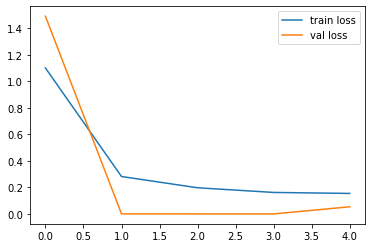

In [31]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')

plt.legend()
plt.show()

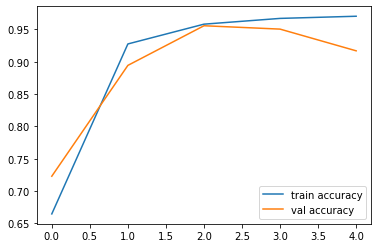

In [32]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [34]:
model = load_model('C:/Users/Owner/Desktop/Produce Item Recognition/res_4.h5')

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [36]:
test_image_files = glob(test_path + '/*/*.jp*g')

In [38]:
predictions = model.predict_generator(test_generator)

In [39]:
import numpy
import sklearn.metrics as metrics
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
print(len(predictions), len(true_classes),len(test_image_files))

class_labels = list(test_generator.class_indices.keys()) 

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

7680 7680 7680
               precision    recall  f1-score   support

        Apple       0.88      0.83      0.85       320
      Avocado       1.00      0.98      0.99       320
       Banana       0.96      1.00      0.98       320
    Blueberry       0.94      0.98      0.96       320
     Brocolli       0.95      0.92      0.93       320
      Cabbage       0.99      0.78      0.87       320
  Canada Pear       0.77      0.97      0.86       320
       Carrot       0.96      0.96      0.96       320
       Garlic       0.64      1.00      0.78       320
   Green Peas       0.78      0.97      0.86       320
 Green Pepper       1.00      0.88      0.94       320
      Lettuce       0.96      0.81      0.88       320
      Mangoes       0.84      0.65      0.73       320
         Okra       0.97      0.97      0.97       320
       Orange       0.94      1.00      0.97       320
    Pineapple       0.82      0.99      0.90       320
   Red Chilli       0.94      1.00      0.97     

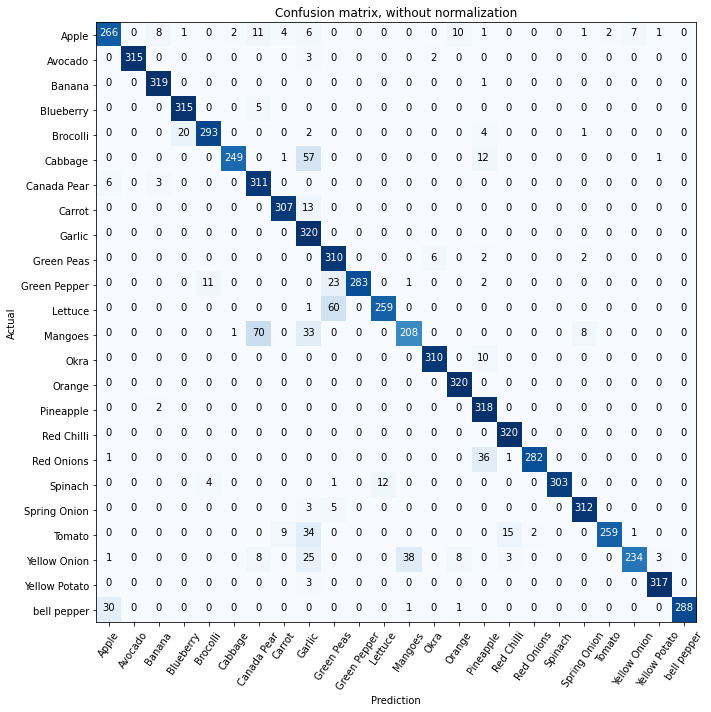

In [40]:

from sklearn.metrics import classification_report, confusion_matrix
import itertools

cm=confusion_matrix(test_generator.classes, predicted_classes)
classes=class_labels
np.set_printoptions(precision=2)
plt.figure(figsize=(15,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix, without normalization')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=55)
plt.yticks(tick_marks, classes)
normalize=False
fmt ='d'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tight_layout()

In [ ]:

test_gen_class_indices={'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blueberry': 3, 'Brocolli': 4, 'Cabbage': 5, 'Canada Pear': 6, 'Carrot': 7, 'Garlic': 8, 'Green Peas': 9, 'Green Pepper': 10, 'Lettuce': 11, 'Mangoes': 12, 'Okra': 13, 'Orange': 14, 'Pineapple': 15, 'Red Chilli': 16, 'Red Onions': 17, 'Spinach': 18, 'Spring Onion': 19, 'Tomato': 20, 'Yellow Onion': 21, 'Yellow Potato': 22, 'bell pepper': 23}
Dir=list(test_gen_class_indices.keys())
final_result={}
for item in Dir:
    print(final_result)
    path=test_path+item+"/"
    image_files = glob(path + '*.jp*g')
    
    perc=0
    for i in range(1000):
      imgfile=np.random.choice(image_files)
      img = image.load_img(imgfile, target_size=(100,100))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])

      classes = model.predict(images)

      a=classes.tolist()

      for i in a[0]:
        if i>=0.7:
          pos=a[0].index(i)
          val=i
      
      for j in test_gen_class_indices.keys():
        if test_gen_class_indices[j]==pos:
         
          if j==item:
            perc=perc+1
        
    
    
    final_result[item]=(perc/1000*100)

{}
{'Apple': 0.0}
